In [ ]:
'''
Deep Learning Stock Price Predictor 
Author: Gil Akos
Objective: Create Deep Learning Model with Keras MultiLayer Perceptron
Reference: http://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/
'''

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import required libraries for Machine Learning
import math
import numpy as np
# Fix random seed for reproducibility
np.random.seed(7)
import pandas as pd

# Import Keras Libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import mean_squared_error

# Import required libraries for Yahoo Finance API
import yahoo_finance as yf
from yahoo_finance import Share

# Import required libraries for visualization and printing
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 12)
import matplotlib.dates as mdates

# Import utility libraries
import utilities as util
import datetime
import time

Using TensorFlow backend.


In [21]:
# Set Benchmark Dates based on Machine Learning for Trading course 1/1/09-6/18/15
date_start, date_end = '1995-01-01', '2015-06-18'#'2015-06-18'

# Set Additional Tickers
tick_0 = 'SPY'
tick_1 = 'GE'
tick_2 = 'MSFT'
tick_3 = 'AAPL'

# Set Baseline Model Ticker
base_ticker = tick_3

In [22]:
#Request Stock Data
stock_data = Share(base_ticker)
stock_historical = stock_data.get_historical(date_start,date_end)

#pprint(stock_historical)

#Define columns of data to keep from historical stock data
stock_item = []
stock_date = []
stock_close = []
stock_volume = []

#Loop through the stock data objects backwards and store factors we want to keep
i_counter = 0
for i in xrange(len(stock_historical)-1,-1,-1):
    d = stock_historical[i]
    stock_item.append(i_counter)
    stock_date.append(d['Date'])
    stock_close.append(d['Adj_Close'])
    stock_volume.append(d['Volume'])
    i_counter += 1

#Create a dataframe for stock data
stock_df = pd.DataFrame()
    
#Add factors to dataframe
stock_df['Item'] = stock_item
stock_df['Date'] = stock_date
stock_df['Adj_Close'] = pd.to_numeric(stock_close)
stock_df['Volume'] = pd.to_numeric(stock_volume)

#Print the dataframe head and tail
print(stock_df.head())
print("---")
print(stock_df.tail())

   Item        Date  Adj_Close     Volume
0     0  1995-01-03   1.228913   25967200
1     1  1995-01-04   1.260937   39670400
2     2  1995-01-05   1.244925   18410000
3     3  1995-01-06   1.344999  269155600
4     4  1995-01-09   1.319479   68521600
---
      Item        Date   Adj_Close    Volume
5147  5147  2015-06-12  122.781413  36886200
5148  5148  2015-06-15  122.540040  43988900
5149  5149  2015-06-16  123.196574  31494100
5150  5150  2015-06-17  122.906931  32918100
5151  5151  2015-06-18  123.466910  35407200


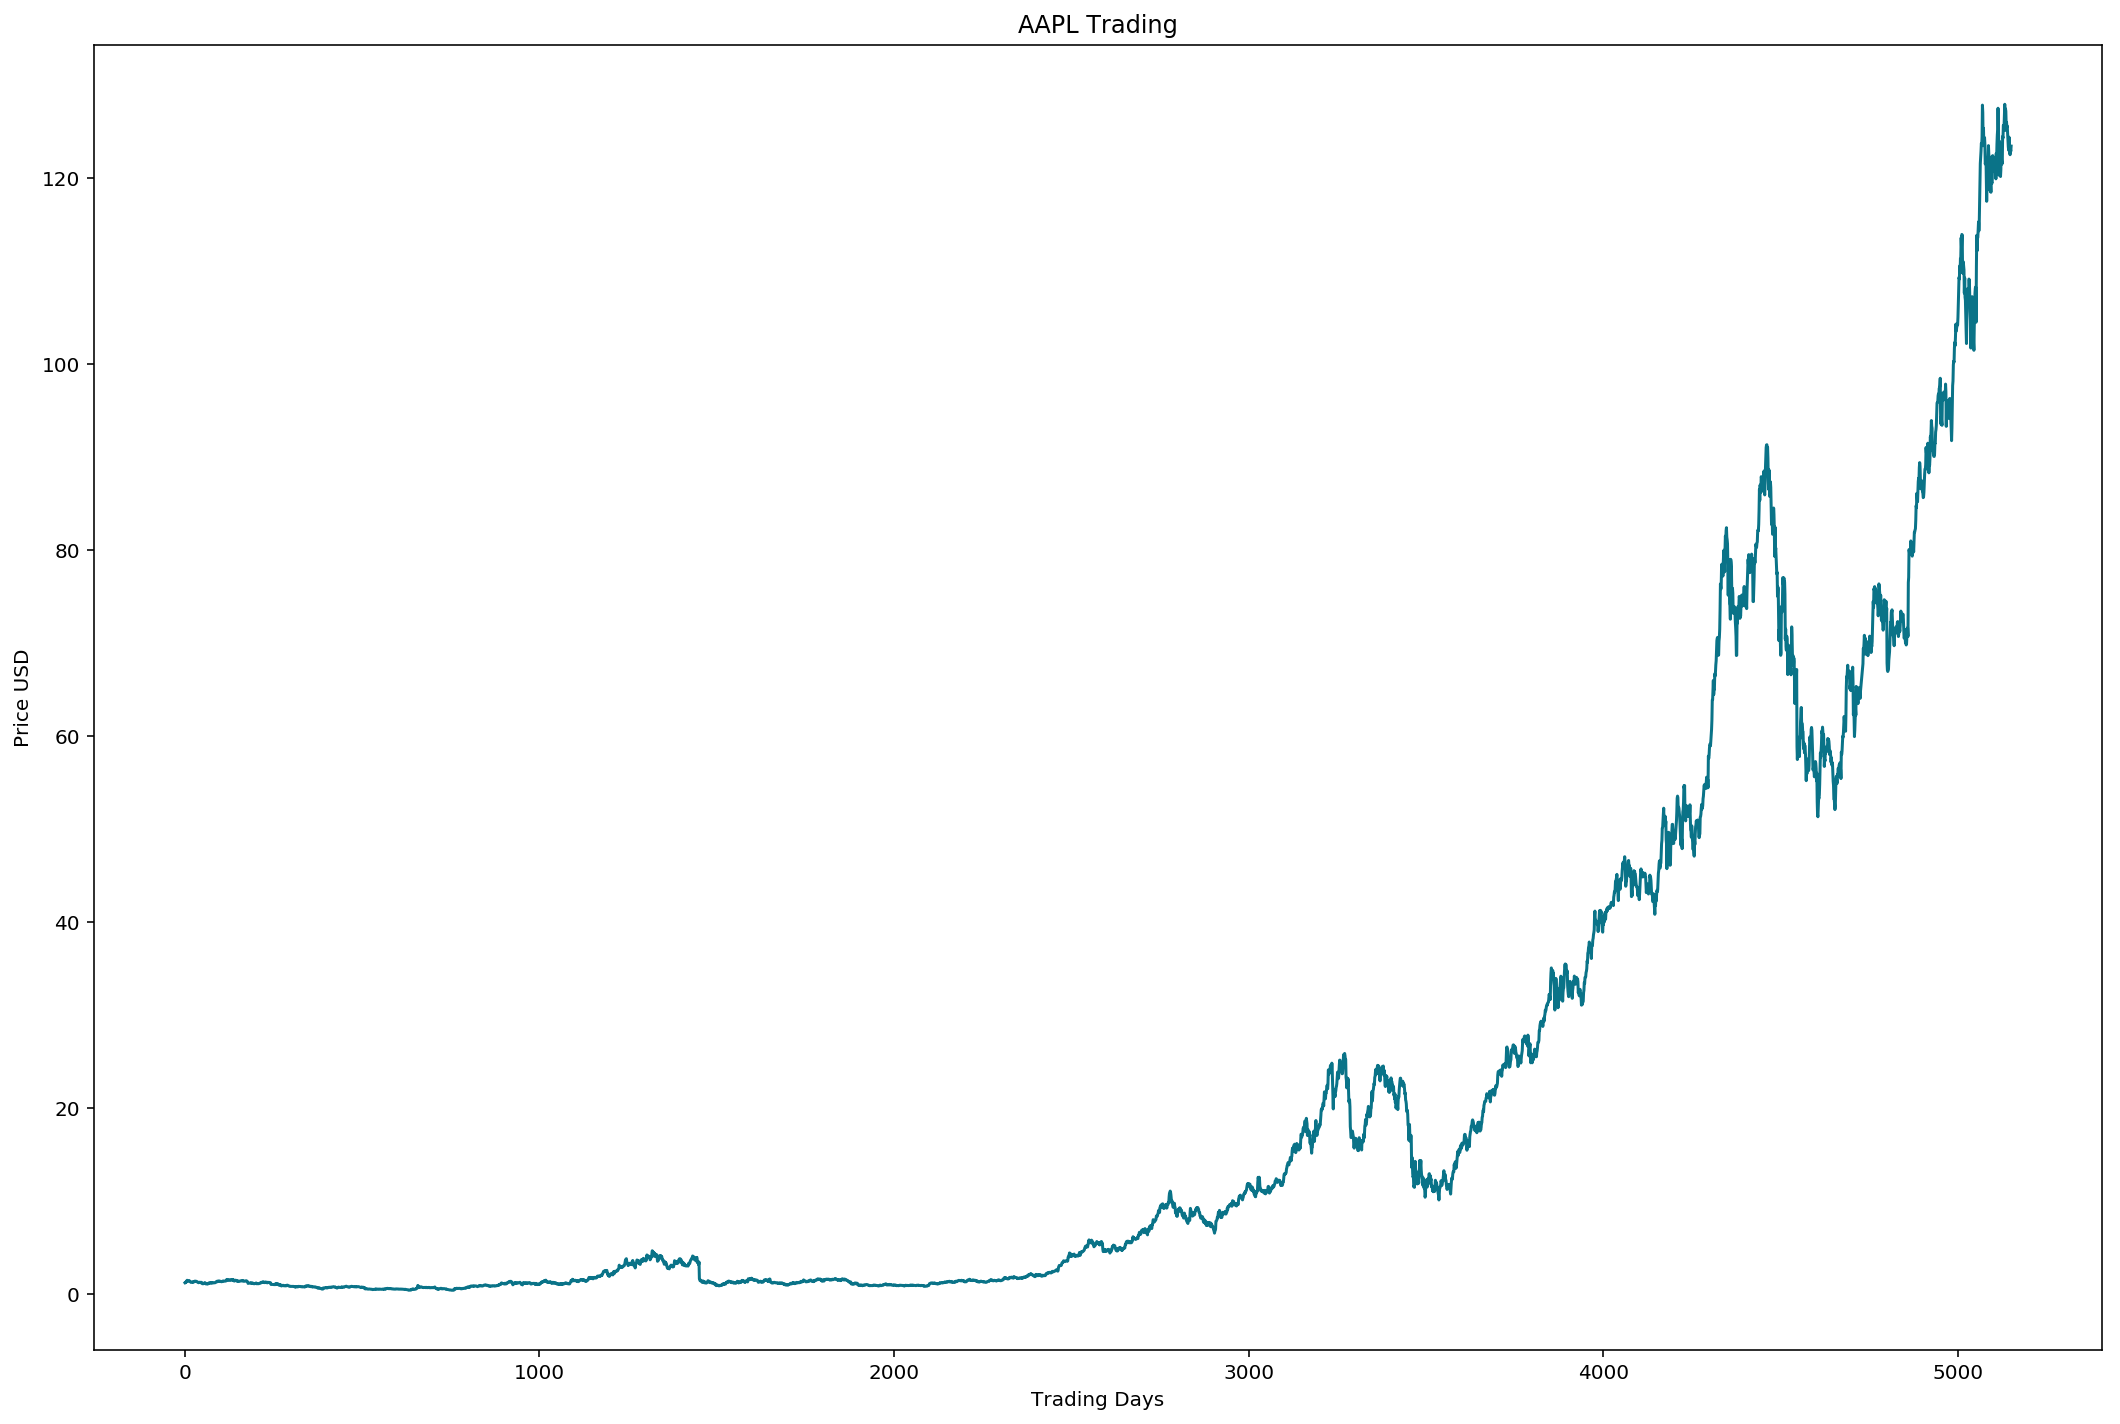

In [23]:
#Plot Basic Data
fig, ax = plt.subplots()
ax.plot(stock_df['Item'], stock_df['Adj_Close'], '#0A7388')

# format the coords message box
def price(x):
    return '$%1.2f' % x
#ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = price
ax.set_title(base_ticker + ' Trading')

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')

plt.show()

In [24]:
#Create numpy arrays for features and targets
X_all = []
y_all = []

#Convert dataframe columns to numpy arrays for scikit learn
for index, row in stock_df.iterrows():
    #print([np.array(row['Item'])])
    X_all.append([row['Item']])
    y_all.append([row['Adj_Close']])

#pprint(X_all)
pprint(y_all)

[[1.228913],
 [1.260937],
 [1.244925],
 [1.344999],
 [1.319479],
 [1.399039],
 [1.497112],
 [1.45308],
 [1.437068],
 [1.425059],
 [1.441071],
 [1.461085],
 [1.469091],
 [1.365014],
 [1.353005],
 [1.33299],
 [1.312473],
 [1.26494],
 [1.276949],
 [1.2849549999999998],
 [1.292961],
 [1.2849549999999998],
 [1.33299],
 [1.296964],
 [1.296964],
 [1.3069709999999999],
 [1.355007],
 [1.397038],
 [1.401041],
 [1.404898],
 [1.378807],
 [1.366765],
 [1.386835],
 [1.364758],
 [1.31659],
 [1.310569],
 [1.290499],
 [1.252366],
 [1.2282819999999999],
 [1.268422],
 [1.284478],
 [1.284478],
 [1.292506],
 [1.27645],
 [1.230289],
 [1.270429],
 [1.27645],
 [1.268422],
 [1.2242680000000001],
 [1.1239190000000001],
 [1.1239190000000001],
 [1.131946],
 [1.127932],
 [1.131946],
 [1.164058],
 [1.222261],
 [1.192156],
 [1.212226],
 [1.1941629999999999],
 [1.103849],
 [1.103849],
 [1.13596],
 [1.131946],
 [1.139975],
 [1.087793],
 [1.115891],
 [1.1801139999999999],
 [1.1801139999999999],
 [1.1761],
 [1.212226],


In [25]:
# Regularize the feature and target arrays and store min/max of input data for rescaling later
X_bounds = [min(X_all), max(X_all)]
X_bounds = [X_bounds[0][0], X_bounds[1][0]]
y_bounds = [min(y_all), max(y_all)]
y_bounds = [y_bounds[0][0], y_bounds[1][0]]

X_scaled, X_range = util.scale_range(np.array(X_all), input_range=X_bounds, target_range=[0.0, 1.0])
y_scaled, y_range = util.scale_range(np.array(y_all), input_range=y_bounds, target_range=[0.0, 1.0])

pprint(y_scaled)
print(y_range)

array([[ 0.00634957],
       [ 0.00660065],
       [ 0.00647511],
       ..., 
       [ 0.96260582],
       [ 0.96033495],
       [ 0.96472532]])
[0.41904399999999997, 127.96609099999999]


In [26]:
# Create datasets
tt_split = .315
tti_split = int(math.floor(len(stock_df['Item'])*(tt_split)))

# Set up training and test sets
X_train = X_scaled[:-tti_split]
X_test = X_scaled[-tti_split:]
print(len(X_train))
print(len(X_test))

y_train = y_scaled[:-tti_split]
y_test = y_scaled[-tti_split:]

#pprint(X_train)
#pprint(X_test)

3530
1622


In [27]:
# Convert an array of values into a dataset matrix
def create_mlp_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [62]:
# Reshape dataset for MLP
look_back = 5
trainX, trainY = create_mlp_dataset(X_train, look_back)
testX, testY = create_mlp_dataset(y_test, look_back)

pprint(trainX)
print('--')
pprint(trainY)

array([[  0.00000000e+00,   1.94137061e-04,   3.88274122e-04,
          5.82411182e-04,   7.76548243e-04],
       [  1.94137061e-04,   3.88274122e-04,   5.82411182e-04,
          7.76548243e-04,   9.70685304e-04],
       [  3.88274122e-04,   5.82411182e-04,   7.76548243e-04,
          9.70685304e-04,   1.16482236e-03],
       ..., 
       [  6.83556591e-01,   6.83750728e-01,   6.83944865e-01,
          6.84139002e-01,   6.84333139e-01],
       [  6.83750728e-01,   6.83944865e-01,   6.84139002e-01,
          6.84333139e-01,   6.84527276e-01],
       [  6.83944865e-01,   6.84139002e-01,   6.84333139e-01,
          6.84527276e-01,   6.84721413e-01]])
--
array([ 0.00097069,  0.00116482,  0.00135896, ...,  0.68452728,
        0.68472141,  0.68491555])


In [63]:
# Create Keras Model
# http://machinelearningmastery.com/time-series-prediction-with-deep-learning-in-python-with-keras/

# Set up hyperparameters
batch_size = 2
epochs = 1

# Create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))

# Compile the model
start = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
print 'compilation time : ', time.time() - start


compilation time :  0.475028038025


In [64]:
# Train the model
model.fit(
    trainX, 
    trainY, 
    nb_epoch=epochs, 
    batch_size=batch_size,
    verbose=2)

Epoch 1/1
2s - loss: 2.1064e-04


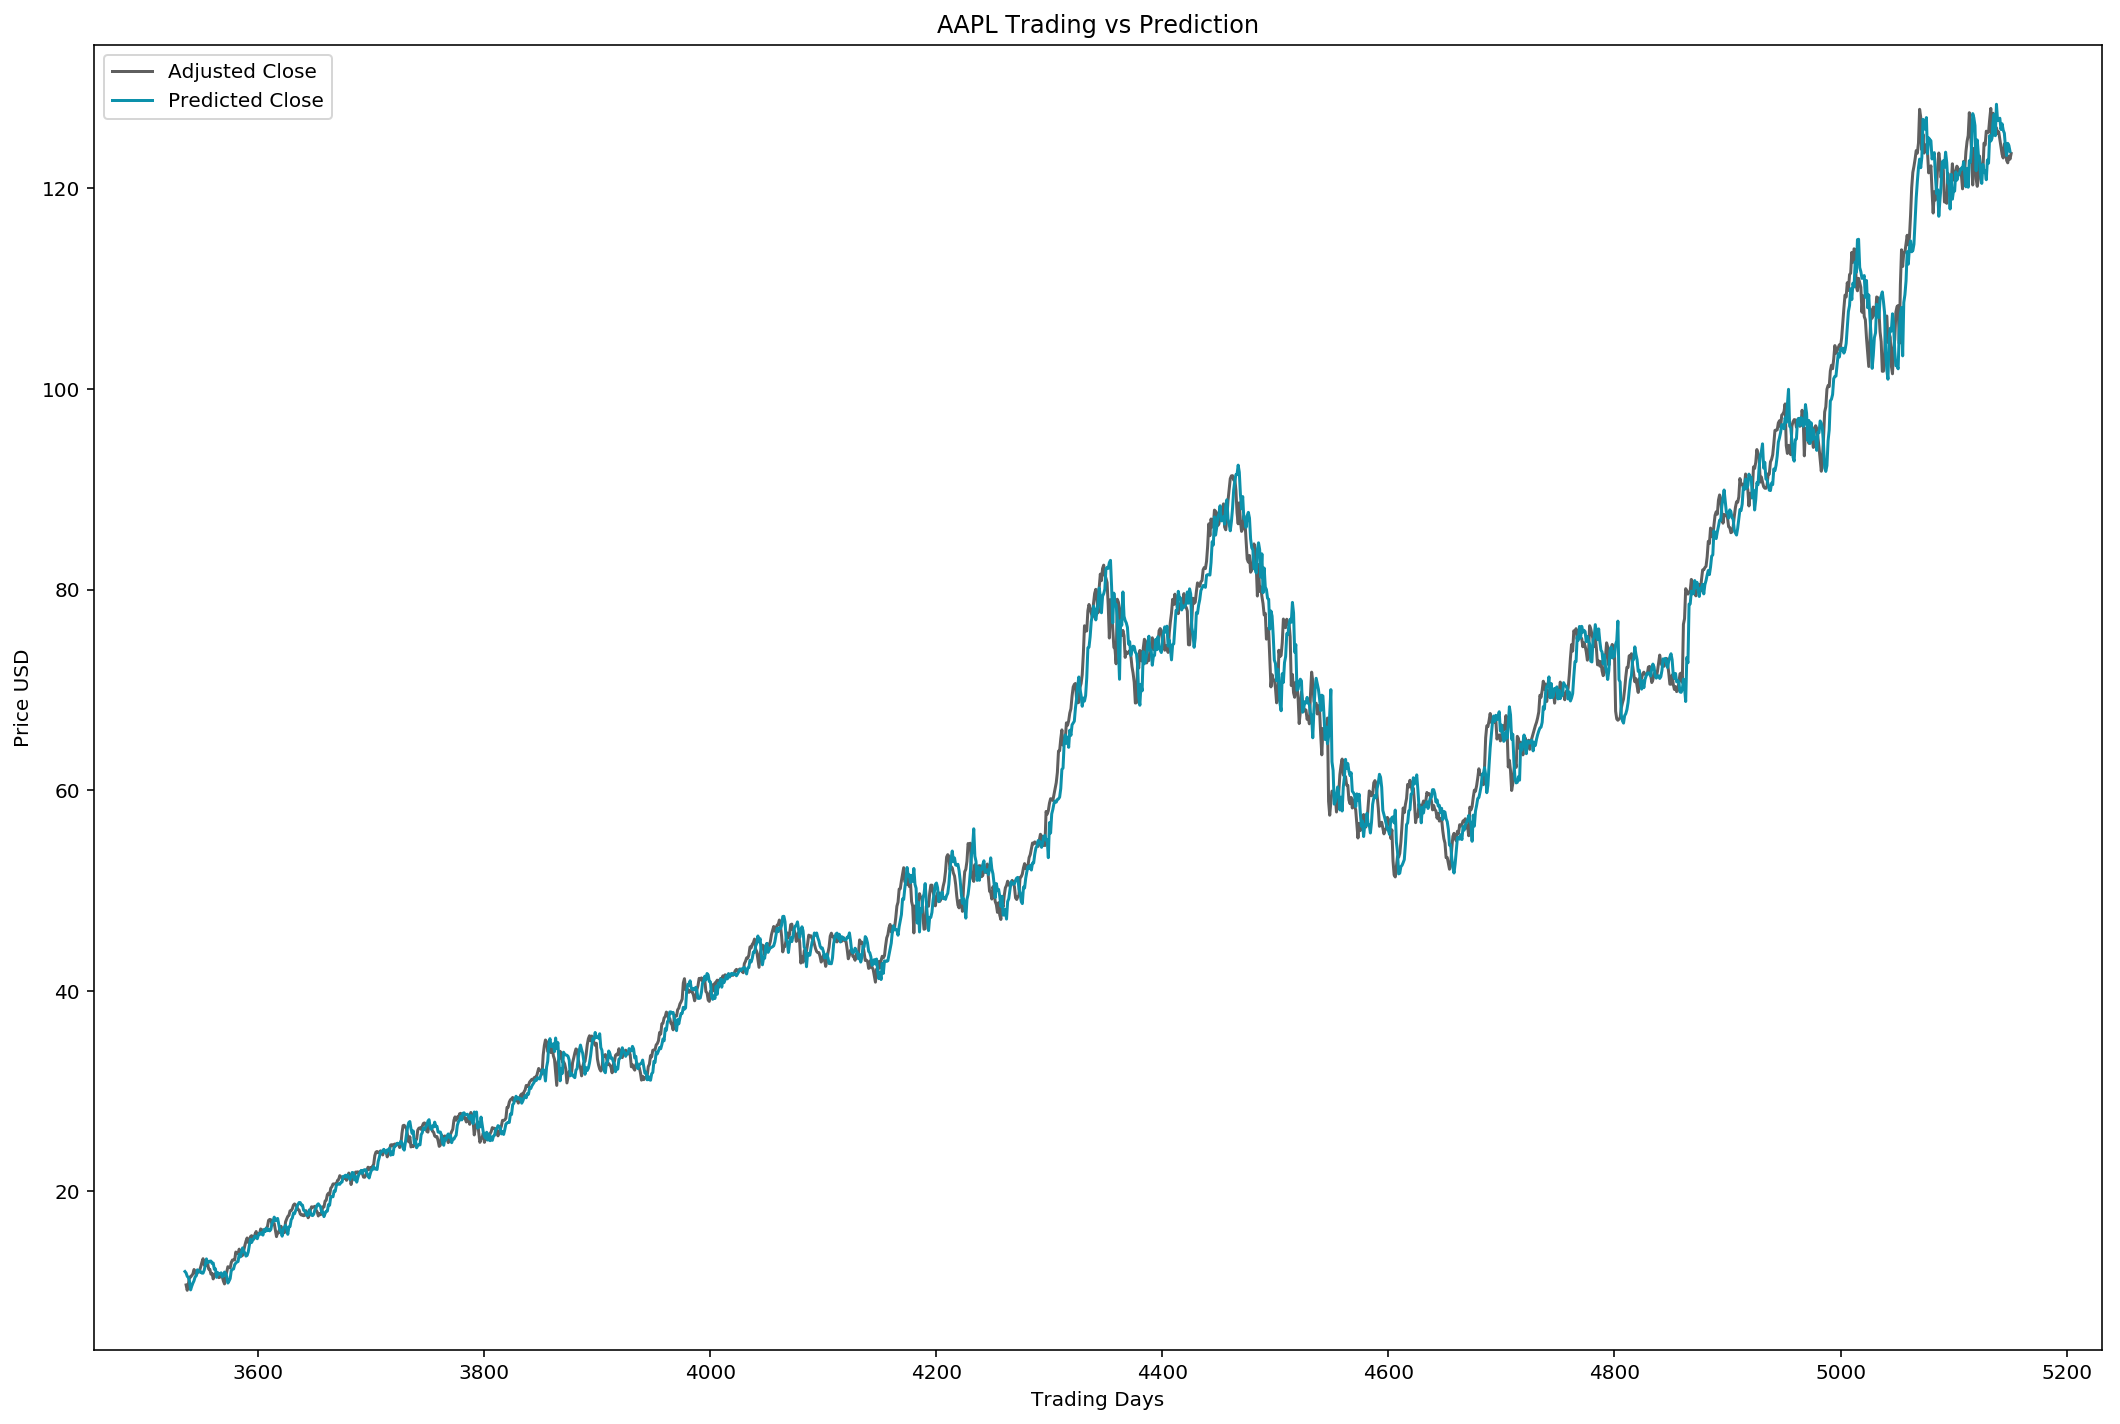

In [65]:
# Generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict_rescaled, r1 = util.scale_range(np.array(trainPredict), input_range=[0.0, 1.0], target_range=y_bounds)
testPredict_rescaled, r2 = util.scale_range(np.array(testPredict), input_range=[0.0, 1.0], target_range=y_bounds)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(X_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict_rescaled)+look_back, :] = trainPredict_rescaled
 
# shift test predictions for plotting
testPredictPlot = np.empty_like(X_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict_rescaled)+(look_back*2)+1:len(X_scaled)-1, :] = testPredict_rescaled

# Create actual values in aligned array
yPlot = np.empty_like(y_scaled)
yPlot[:, :] = np.nan
yPlot[-len(testPredict_rescaled):, :] = y_all[-len(testPredict_rescaled):]


# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(yPlot,'#5F5F5F', label='Adjusted Close')
plt.plot(testPredictPlot, '#0C91AB', label='Predicted Close')

# Set title
ax.set_title(base_ticker + ' Trading vs Prediction')
ax.legend(loc='upper left')

plt.show()

In [66]:
# The mean squared error
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.4f MSE (%.4f RMSE)' % (testScore, math.sqrt(testScore)))

Test Score: 0.0003 MSE (0.0182 RMSE)


# Study Insights:

From Polynomial to MultiLayer Perceptron, MSE improved dramatically: 

0.1219 to 0.3895 to 0.0002

# Log of Results:
Lookback: 3

Epochs: 1


### SPY
Lookback: 3 Mean squared error: 0.0002



### GE


### MSFT


### AAPL
Lookback: 1 Mean squared error: 0.0021

Lookback: 2 Mean squared error: 0.0024

Lookback: 3 Mean squared error: 0.0006

Lookback: 5 Mean squared error: 0.0003

Lookback: 10 Mean squared error: 0.0003

Lookback: 20 Mean squared error: 0.0008
